In [ ]:
import scipy.io as io
import numpy as np
from utils import utils
import cv2
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
# load data
#data

x_test_mat = io.loadmat('./data/x_valid.mat')
x_test = x_test_mat['x_test_main']


x_cluster = io.loadmat('./data/x_cluster.mat')
x_cluster = x_cluster['x_cluster']

In [ ]:
#pre-processing
def standarl(x):
    siz = x.shape
    xs = np.copy(x)  # Make a copy of input array
    for i in range(siz[0]):
        for j in range(3):
            tem = x[i,:,j]
            mean = np.mean(tem)
            std_dev = np.std(tem)
            xs[i,:,j] = (tem - mean) / std_dev
    return xs

#reshape input to 64x64
def resize_stft(x_in):
  batch_num = x_in.shape[0]

  # Initialize an empty array to store resized images
  resized_input = np.zeros((batch_num, 64, 64, 3), dtype=np.float32)

  # Loop through each image in the batch and resize
  for i in range(batch_num):
      # Resize each image to (64, 64)
      resized_image = cv2.resize(x_in[i], (64, 64), interpolation=cv2.INTER_LINEAR)

      # Store the resized image in the new array
      resized_input[i] = resized_image


# Now 'resized_images' contains all the images resized to (64, 64, 3) with dtype float32
  return resized_input


x_train_n = utils.norml(x_cluster)
x_test_n = utils.norml(x_test)

x_train_stft = utils.batch_stft(x_train_n,nfft=128,overlap=0.7)
x_test_stft = utils.batch_stft(x_test_n,nfft=128,overlap=0.7)


resized_x_train = resize_stft(x_train_stft)
resized_x_test = resize_stft(x_test_stft)

In [ ]:
# model for 4x4x16 feature output

# Input layer
input_img = Input(shape=(64, 64, 3))
# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.1)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.1)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Display the summary of the model
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                     

In [ ]:
#model training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.9, mode='auto')
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
history1 = autoencoder.fit(resized_x_train, resized_x_train, epochs=200, batch_size=1024, validation_data=(resized_x_test, resized_x_test),callbacks=[reduce_lr],shuffle=True)

Epoch 1/200
2/2 [==============================] - 4s 645ms/step - loss: 0.0060 - val_loss: 0.0038 - lr: 0.0010
Epoch 2/200
2/2 [==============================] - 1s 278ms/step - loss: 0.0056 - val_loss: 0.0036 - lr: 0.0010
Epoch 3/200
2/2 [==============================] - 1s 288ms/step - loss: 0.0040 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/200
2/2 [==============================] - 1s 301ms/step - loss: 0.0040 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/200
2/2 [==============================] - 1s 303ms/step - loss: 0.0037 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/200
2/2 [==============================] - 1s 295ms/step - loss: 0.0035 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/200
2/2 [==============================] - 1s 281ms/step - loss: 0.0031 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/200
2/2 [==============================] - 1s 303ms/step - loss: 0.0031 - val_loss: 0.0025 - lr: 0.0010
Epoch 9/200
2/2 [==============================] - 1s 303ms/step - loss: 0.0031 - val_loss: 0.0024 - lr:

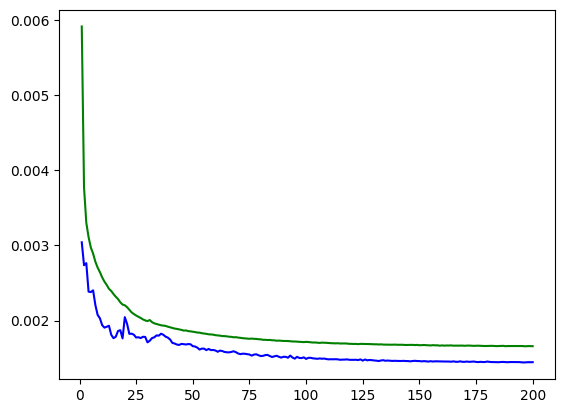

In [ ]:
import matplotlib.pyplot as plt
# Extract loss values for model
loss_values1 = history1.history['loss']
val_loss_values1 = history1.history['val_loss']
epochs = range(1, len(loss_values1) + 1)
plt.plot(epochs, loss_values1, label='Training Loss', color='blue')
plt.plot(epochs, val_loss_values1, label='Validation Loss', color='green')

4/4 [==============================] - 0s 33ms/step


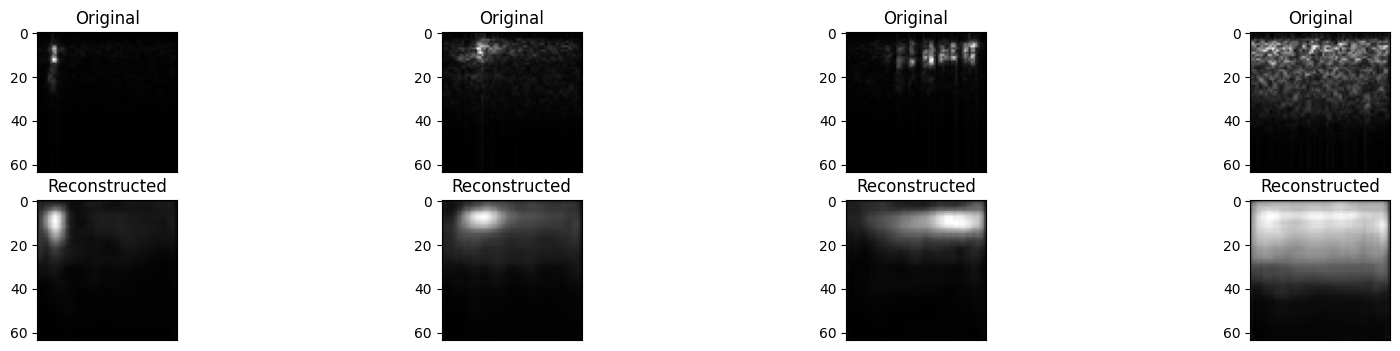

In [ ]:
output = autoencoder.predict(resized_x_test, batch_size=256)
import matplotlib.pyplot as plt
lis = [4,10,12,15]
n = len(lis)
plt.figure(figsize=(20, 4))
for i in range(len(lis)):
    # Original Image (Input)
    ax = plt.subplot(2, n, i + 1)
    num = lis[i]
    plt.imshow(resized_x_test[num,:,:,1]) # Reshape if needed
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

    # Reconstructed Image (Output)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[num,:,:,1])  # Reshape if needed
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

plt.show()